# Experiment - metrics sensitivity to detecting noisy examples

In other papers it has been obesrved that suggested metrics can be used for detecting examples with **noisy labels** or **noisy data**. In our case since we do not want to rely on information from labels, our only option is to observe how MSD and loss gradient norm are affected by noisy data and can we use them to detect them

## Experiment setup 

1. Select a stratified w.r.t. labels subset of original CIFAR-10 dataset and produce new images $\hat x = 0.5 x_{i} + 0.5 x_{j}$, where $y_{i} \neq y_{j}$
2. Append this subset $\hat X$ to original data $X$ and train model on it, while collecting MSD and loss gradient norm history
3. Evaluate statistics on original data and on noised data, make a conclusion if there $\exists$ such threshold for any of statistics that, if selected optimally, could separate noised data, report best quality of such threshold

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# To be able to import from parent directory
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [219]:
from utils import model_param_count, plot_images
from utils import IndexedDataset, RepresentationBuffer, MeanSquareDistancesStat

import random

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torchvision
from torchvision import datasets
import torchvision.transforms as T

DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
SEED=42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(DEVICE)

cuda


In [220]:
from itertools import combinations
from sklearn.model_selection import train_test_split
from PIL import Image

class NoisySubset(Dataset):
    """Class that is responsible for access to noied data (mixed images). Mixing is stratified across all classes"""
    def __init__(self, n_per_label, n_labels, orig_dataset):
        """
        n_per_label_mix: int - number of images per possible combination of labels
        n_labels: int - number of labels
        orig_dataset: Dataset - original dataset
        """
        self.n_pairs = int(n_labels * (n_labels - 1) / 2)
        self._len = self.n_pairs * (n_per_label ** 2)
        self.label_comb = list(combinations(range(n_labels), 2))
        self.n_per_label = n_per_label
        self.n_labels = n_labels

        noisy_idx, _, noisy_labels, _ = train_test_split(np.arange(len(orig_dataset)),
                                        np.array(ds.targets),
                                        train_size=self._len / len(orig_dataset),
                                        random_state=SEED,
                                        stratify=ds.targets)
        
        self.ordered_noisy_idx = noisy_idx[np.argsort(noisy_labels)]
        self._ds = ds
        
    def __getitem__(self, idx):
        label1, label2 = self.label_comb[idx // (self.n_per_label ** 2)]
        img_pair = idx % (self.n_per_label ** 2)
        img1_ord, img2_ord = img_pair // self.n_per_label, img_pair % self.n_per_label

        idx1 = self.ordered_noisy_idx[label1*(self.n_pairs*self.n_per_label) + img1_ord] # idk why this works like that
        idx2 = self.ordered_noisy_idx[label2*(self.n_pairs*self.n_per_label) + img2_ord]

        img1, y1 = self._ds[idx1]
        img2, y2 = self._ds[idx2]
        
        assert y1 == label1
        assert y2 == label2
        
        return Image.fromarray(0.5 * np.array(img1) + 0.5 * np.array(img2), mode="RGB"), label1 # label is not important

    def __len__(self):
        return self._len
        
class JointDataset(Dataset):
    def __init__(self, ds, n_per_label, n_labels, transform=None):
        self.ds = ds
        self.noisy_subs = NoisySubset(n_per_label, n_labels, ds)
        self.transform = transform

    def __getitem__(self, idx):
        if idx >= len(self.ds):
            x, y = self.noisy_subs[idx - len(self.ds)]
        else:
            x, y = self.ds[idx]

        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.ds) + len(self.noisy_subs)


In [221]:
from lightly.loss import BarlowTwinsLoss
from lightly.models.modules import BarlowTwinsProjectionHead
from lightly.transforms.byol_transform import (
    BYOLView1Transform,
    BYOLView2Transform,
    MultiViewTransform
)
from lightly.transforms.utils import IMAGENET_NORMALIZE


CHS = 3
IMG_SIZE = (32, 32)
BS = 512

class BYOLTransformWrapped(MultiViewTransform):
        """Appends BYOL transform output with not augmented images"""
        def __init__(self, view_1_transform, view_2_transform):
                view_1_transform = view_1_transform or BYOLView1Transform()
                view_2_transform = view_2_transform or BYOLView2Transform()
                transforms = [
                        T.Compose([T.ToTensor(), T.Normalize(mean=IMAGENET_NORMALIZE["mean"], std=IMAGENET_NORMALIZE["std"])]),
                        view_1_transform, 
                        view_2_transform
                ]
                super().__init__(transforms=transforms)


transform_train = BYOLTransformWrapped( # note: this thing works only with 3
        view_1_transform=BYOLView1Transform(input_size=IMG_SIZE[0], gaussian_blur=0.0),
        view_2_transform=BYOLView2Transform(input_size=IMG_SIZE[0], gaussian_blur=0.0),
)

ds_train = IndexedDataset(JointDataset(datasets.CIFAR10(root='../data', download=True), 
                                       n_per_label=10, 
                                       n_labels=10, 
                                       transform=transform_train))

assert len(ds_train) == 50_000 + 4500 
train_loader = DataLoader(ds_train, batch_size=BS, shuffle=True, drop_last=False)

Files already downloaded and verified


In [222]:
class BarlowTwins(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.projection_head = BarlowTwinsProjectionHead(512, 2048, 2048)

    def forward(self, x):
        x = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(x)
        return z

    def encode(self, x):
        return self.backbone(x).flatten(start_dim=1)

In [223]:
backbone = nn.Sequential(*list(torchvision.models.resnet18().children())[:-1])
print(model_param_count(backbone))

11176512


In [224]:
class LossInfoStat:
    def __init__(self, ds_size, n_epochs):
        self.loss_grad_norm_hist = torch.zeros(n_epochs, ds_size)

        self.n_epochs = n_epochs
        self.cur_epoch = 0

    def push(self, batch):
        idx, loss_grad_norm = batch

        self.loss_grad_norm_hist[self.cur_epoch, idx] = loss_grad_norm

    def inc_epoch(self):
        if self.cur_epoch == self.n_epochs: raise ValueError
        self.cur_epoch += 1

In [225]:
# COLLECT BOTH MSD AND LGN
import gc

NUM_EPOCHS=75

model = BarlowTwins(backbone).to(DEVICE)
criterion = BarlowTwinsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
repr_buffer = RepresentationBuffer(len(ds_train), 512)
msd_tracker = MeanSquareDistancesStat(len(ds_train), NUM_EPOCHS, 512, repr_buffer)
loss_grad_tracker = LossInfoStat(len(ds_train), NUM_EPOCHS)

for epoch in range(NUM_EPOCHS):
    total_loss = 0
    for idx, x, _ in train_loader:
        model.train()
        x_orig, x0, x1 = x
        x_orig = x_orig.to(DEVICE)
        x0 = x0.to(DEVICE)
        x1 = x1.to(DEVICE)

        x0.requires_grad = True
        x1.requires_grad = True

        projection_0 = model(x0)
        projection_1 = model(x1)

        loss = criterion(projection_0, projection_1)
        total_loss += loss.detach()
        
        loss.backward()

        loss_grad_norm = torch.norm(torch.flatten(x0.grad.data + x1.grad.data, start_dim=1), dim=1).cpu()
        loss_grad_tracker.push((idx, loss_grad_norm))
        
        x0.grad = None
        x1.grad = None
        x0.requires_grad = False
        x1.requires_grad = False

        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            z = model.encode(x_orig) # note: repr obtained only from backbone
            z = z.cpu()
            msd_tracker.push((idx, z))

    avg_loss = total_loss / len(train_loader)
    print(f"epoch: {epoch:>02}, loss: {avg_loss:.5f}")
    msd_tracker.inc_epoch()
    loss_grad_tracker.inc_epoch()

    torch.cuda.empty_cache()
    gc.collect()

    print(f"mean msd: {np.mean(msd_tracker.msd_hist[epoch].cpu().detach().numpy()):.3f}")
    print(f"mean lgn: {np.mean(loss_grad_tracker.loss_grad_norm_hist[epoch].cpu().detach().numpy()):.3f}")

epoch: 00, loss: 1469.12866
mean msd: 0.000
mean lgn: 0.752
epoch: 01, loss: 1220.29517
mean msd: 3.236
mean lgn: 0.342
epoch: 02, loss: 1037.69946
mean msd: 3.276
mean lgn: 0.357
epoch: 03, loss: 942.04547
mean msd: 3.719
mean lgn: 0.386
epoch: 04, loss: 882.36926
mean msd: 3.886
mean lgn: 0.412
epoch: 05, loss: 838.73181
mean msd: 4.137
mean lgn: 0.399
epoch: 06, loss: 797.33148
mean msd: 4.277
mean lgn: 0.412
epoch: 07, loss: 761.66833
mean msd: 4.385
mean lgn: 0.433
epoch: 08, loss: 735.36145
mean msd: 4.588
mean lgn: 0.473
epoch: 09, loss: 710.53925
mean msd: 4.494
mean lgn: 0.489
epoch: 10, loss: 693.68652
mean msd: 4.528
mean lgn: 0.517
epoch: 11, loss: 679.46661
mean msd: 4.373
mean lgn: 0.534
epoch: 12, loss: 660.51373
mean msd: 4.376
mean lgn: 0.553
epoch: 13, loss: 648.54742
mean msd: 4.392
mean lgn: 0.564
epoch: 14, loss: 638.64185
mean msd: 4.177
mean lgn: 0.571
epoch: 15, loss: 628.14978
mean msd: 4.220
mean lgn: 0.594
epoch: 16, loss: 612.15100
mean msd: 4.123
mean lgn: 

In [226]:
# save tensor with msd hist for later
torch.save(loss_grad_tracker.loss_grad_norm_hist, '../data/loss_grad_noisy.pt')
torch.save(msd_tracker.msd_hist, '../data/msd_hist_noisy.pt')

# 1. Analysis of MSD

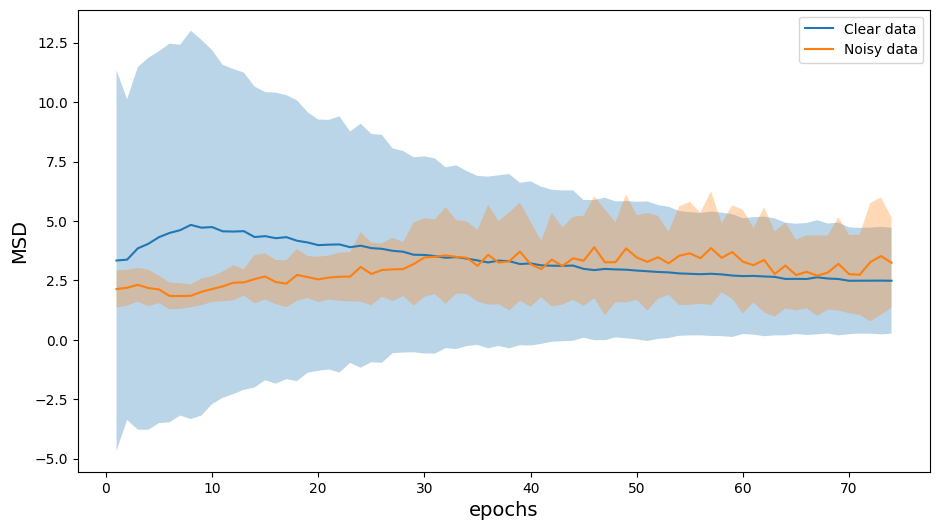

In [242]:
plt.figure(figsize=(11, 6))
msd_hist = np.array(msd_tracker.msd_hist[1:NUM_EPOCHS])
msd_hist_clear = np.array(msd_tracker.msd_hist[1:NUM_EPOCHS, :50_000])
msd_hist_noisy = np.array(msd_tracker.msd_hist[1:NUM_EPOCHS, 50_000:])

clear_mean = msd_hist_clear.mean(axis=1)
noisy_mean = msd_hist_noisy.mean(axis=1)

clear_std = np.std(msd_hist_clear, axis=1)
noisy_std = np.std(msd_hist_noisy, axis=1)

plt.plot(list(range(1, 75)), clear_mean, label="Clear data")
plt.fill_between(list(range(1, 75)), clear_mean - 1.96*clear_std, clear_mean + 1.96*clear_std, alpha=0.3)

plt.plot(list(range(1, 75)), noisy_mean, label="Noisy data")
plt.fill_between(list(range(1, 75)), noisy_mean - 1.96*noisy_std, noisy_mean + 1.96*noisy_std, alpha=0.3)

plt.xlabel('epochs', fontsize=14)
plt.ylabel('MSD', fontsize=14)
plt.legend()
plt.show()

In [245]:
clear_mean.shape

(74,)

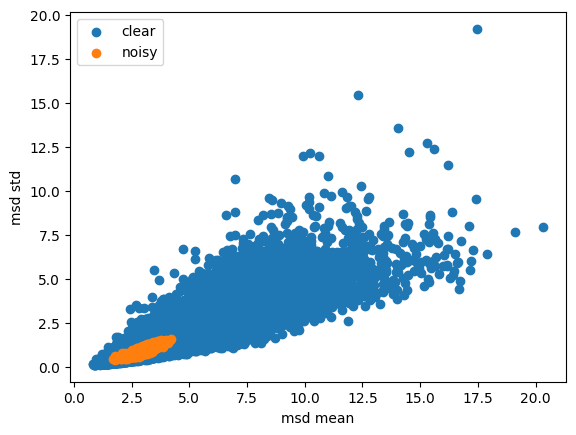

In [247]:
# plot scatter plot
clear_means = msd_hist_clear.mean(axis=0)
noisy_means = msd_hist_noisy.mean(axis=0)

clear_stds = np.std(msd_hist_clear, axis=0)
noisy_stds = np.std(msd_hist_noisy, axis=0)

plt.scatter(clear_means, clear_stds, label='clear')
plt.scatter(noisy_means, noisy_stds, label='noisy')
plt.xlabel('msd mean')
plt.ylabel('msd std')
plt.legend()
plt.show()

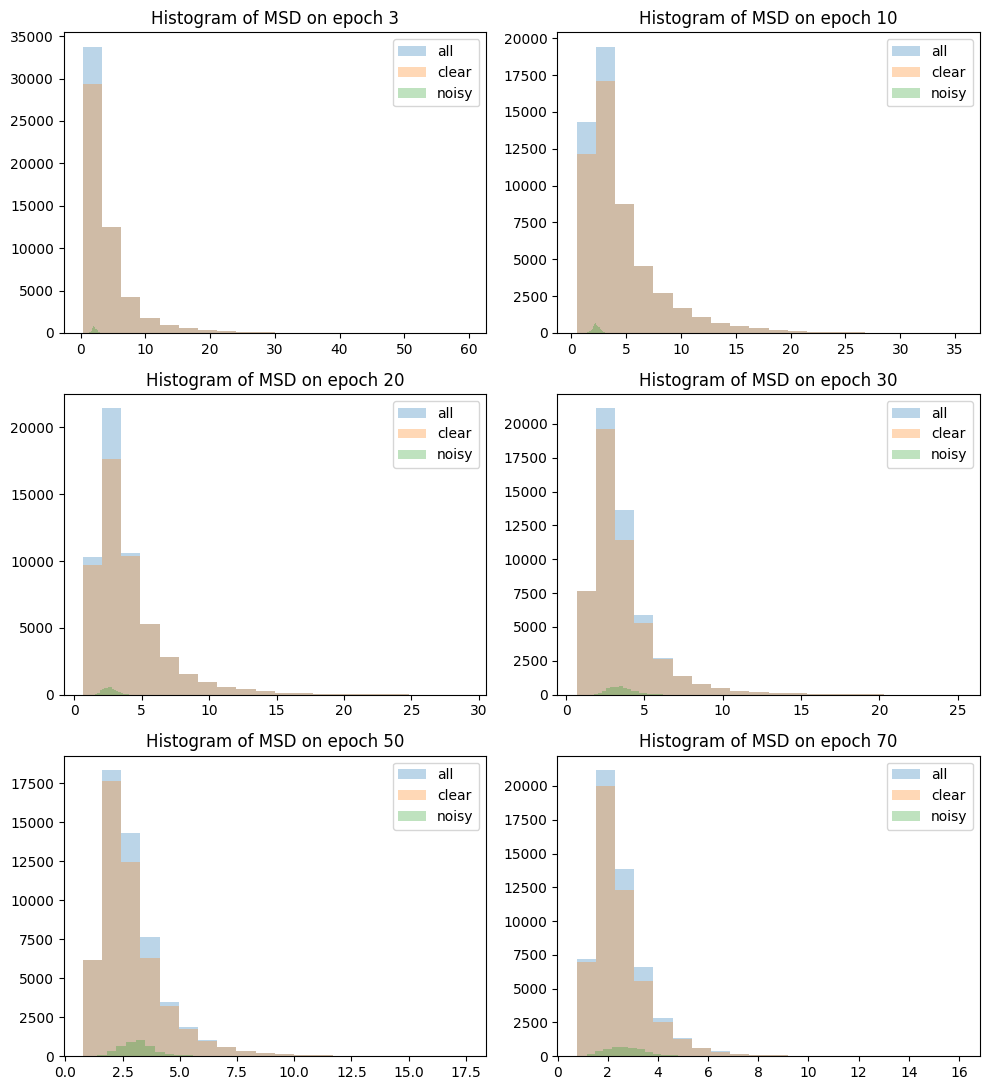

In [243]:
epochs_to_plot = [3, 10, 20, 30, 50, 70]

_, axs = plt.subplots(len(epochs_to_plot)//2, 2, figsize=(10, 11))
for idx, ax in enumerate(axs.flatten()):
    ep = epochs_to_plot[idx]
    ax.hist(msd_hist[ep], bins=20, alpha=0.3, label='all')
    ax.hist(msd_hist_clear[ep], bins=20, alpha=0.3, label='clear')
    ax.hist(msd_hist_noisy[ep], bins=20, alpha=0.3, label='noisy')

    ax.legend()
    ax.set_title(f"Histogram of MSD on epoch {ep}")

plt.tight_layout()
plt.show()

In [248]:
def msd_discrepancy(msd_hist, k, t='diff'):
    first_k_mean = np.mean(msd_hist[1:k+1], axis=0)
    last_k_mean = np.mean(msd_hist[-k:], axis=0)
    if t == 'ratio':
        return first_k_mean / last_k_mean
    elif t == 'diff':
        return first_k_mean - last_k_mean

clear_disr_scores = msd_discrepancy(msd_hist_clear, k=5, t='diff')
noisy_disr_scores = msd_discrepancy(msd_hist_noisy, k=5, t='diff')

In [251]:
noisy_means.shape

(4500,)

In [254]:
import pandas as pd

# form a df frame with label for noisy

df1 = pd.DataFrame(data={'msd_mean': clear_means, 'msd_std': clear_stds, 'disr_score': clear_disr_scores, 'noisy': [0]*50_000})
df2 = pd.DataFrame(data={'msd_mean': noisy_means, 'msd_std': noisy_stds, 'disr_score': noisy_disr_scores, 'noisy': [1]*4500})

df = pd.concat([df1, df2], axis=0)
df.tail()

,msd_mean,msd_std,disr_score,noisy
4495,3.354436,1.265928,-1.725959,1
4496,3.039362,0.998297,-0.976223,1
4497,2.887802,0.874465,-0.706978,1
4498,3.133616,0.910275,-1.188292,1
4499,2.820422,0.852049,-0.413637,1


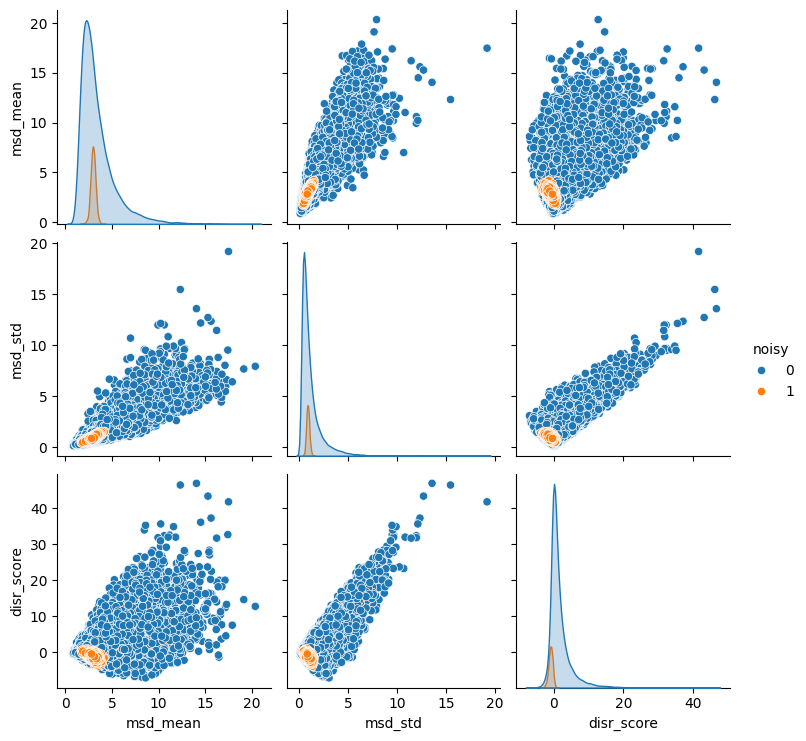

In [256]:
import seaborn as sns

sns.pairplot(df, kind='scatter', hue='noisy')
plt.show()

In [257]:
df.to_csv('../data/msd_clear_noisy.csv', index=False)

## 2. Analysis of LGN

In [266]:
(lgn_hist_noisy < 0).any()

False

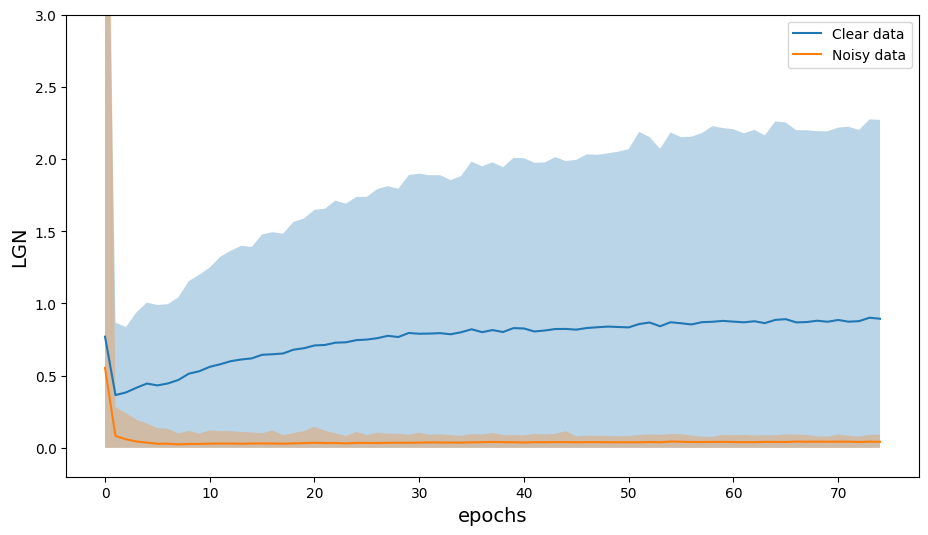

In [274]:
plt.figure(figsize=(11, 6))
lgn_hist = np.array(loss_grad_tracker.loss_grad_norm_hist)
lgn_hist_clear = np.array(loss_grad_tracker.loss_grad_norm_hist[:, :50_000])
lgn_hist_noisy = np.array(loss_grad_tracker.loss_grad_norm_hist[:, 50_000:])

clear_mean = lgn_hist_clear.mean(axis=1)
noisy_mean = lgn_hist_noisy.mean(axis=1)

clear_std = np.std(lgn_hist_clear, axis=1)
noisy_std = np.std(lgn_hist_noisy, axis=1)

plt.plot(clear_mean, label="Clear data")
low_b = clear_mean - 1.96*clear_std
low_b[low_b < 0] = 0
plt.fill_between(list(range(75)), low_b, clear_mean + 1.96*clear_std, alpha=0.3)

plt.plot(noisy_mean, label="Noisy data")
low_b = noisy_mean - 1.96*clear_std
low_b[low_b < 0] = 0
plt.fill_between(list(range(75)), low_b, noisy_mean + 1.96*noisy_std, alpha=0.3)

plt.xlabel('epochs', fontsize=14)
plt.ylabel('LGN', fontsize=14)

plt.ylim(-0.2, 3.0)
plt.legend()
plt.show()

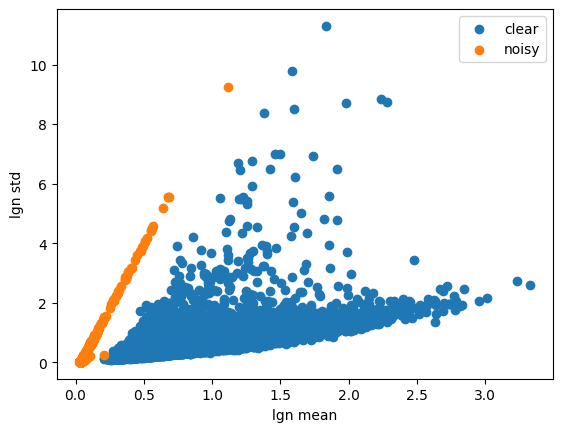

In [276]:
# plot scatter plot
clear_means = lgn_hist_clear.mean(axis=0)
noisy_means = lgn_hist_noisy.mean(axis=0)

clear_stds = np.std(lgn_hist_clear, axis=0)
noisy_stds = np.std(lgn_hist_noisy, axis=0)

plt.scatter(clear_means, clear_stds, label='clear')
plt.scatter(noisy_means, noisy_stds, label='noisy')
plt.xlabel('lgn mean')
plt.ylabel('lgn std')
plt.legend()
plt.show()

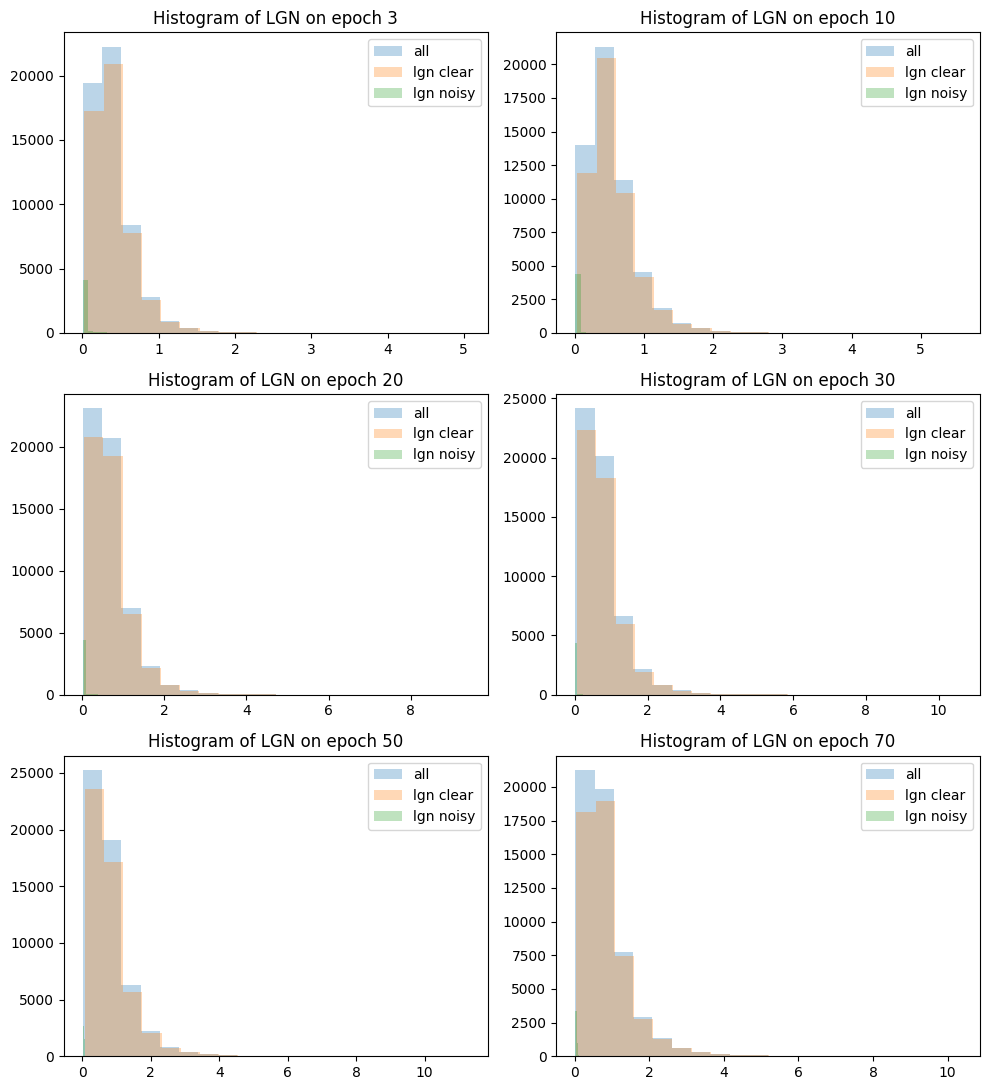

In [277]:
epochs_to_plot = [3, 10, 20, 30, 50, 70]
_, axs = plt.subplots(len(epochs_to_plot)//2, 2, figsize=(10, 11))
for idx, ax in enumerate(axs.flatten()):
    ep = epochs_to_plot[idx]
    ax.hist(lgn_hist[ep], bins=20, alpha=0.3, label='all')
    ax.hist(lgn_hist_clear[ep], bins=20, alpha=0.3, label='lgn clear')
    ax.hist(lgn_hist_noisy[ep], bins=20, alpha=0.3, label='lgn noisy')

    ax.legend()
    ax.set_title(f"Histogram of LGN on epoch {ep}")

plt.tight_layout()
plt.show()

In [290]:
def lgn_discrepancy(lgn_hist, k, t='diff'):
    first_k_mean = np.mean(lgn_hist[:k], axis=0)
    last_k_mean = np.mean(lgn_hist[-k:], axis=0)
    if t == 'ratio':
        return first_k_mean / last_k_mean
    elif t == 'diff':
        return first_k_mean - last_k_mean

clear_disr_scores = lgn_discrepancy(lgn_hist_clear, k=5, t='diff')
noisy_disr_scores = lgn_discrepancy(lgn_hist_noisy, k=5, t='diff')

In [291]:
clear_means.shape, clear_stds.shape, clear_disr_scores.shape

((50000,), (50000,), (50000,))

In [292]:
df1 = pd.DataFrame(data={'lgn_mean': clear_means, 'lgn_std': clear_stds, 'disr_score': clear_disr_scores, 'noisy': [0]*50_000})
df2 = pd.DataFrame(data={'lgn_mean': noisy_means, 'lgn_std': noisy_stds, 'disr_score': noisy_disr_scores, 'noisy': [1]*4500})

df = pd.concat([df1, df2], axis=0)
df.tail()

,lgn_mean,lgn_std,disr_score,noisy
4495,0.032224,0.011879,-0.006965,1
4496,0.035991,0.037310,0.062402,1
4497,0.035193,0.015241,-0.000817,1
4498,0.034132,0.015449,0.011600,1
4499,0.034507,0.016447,0.003215,1


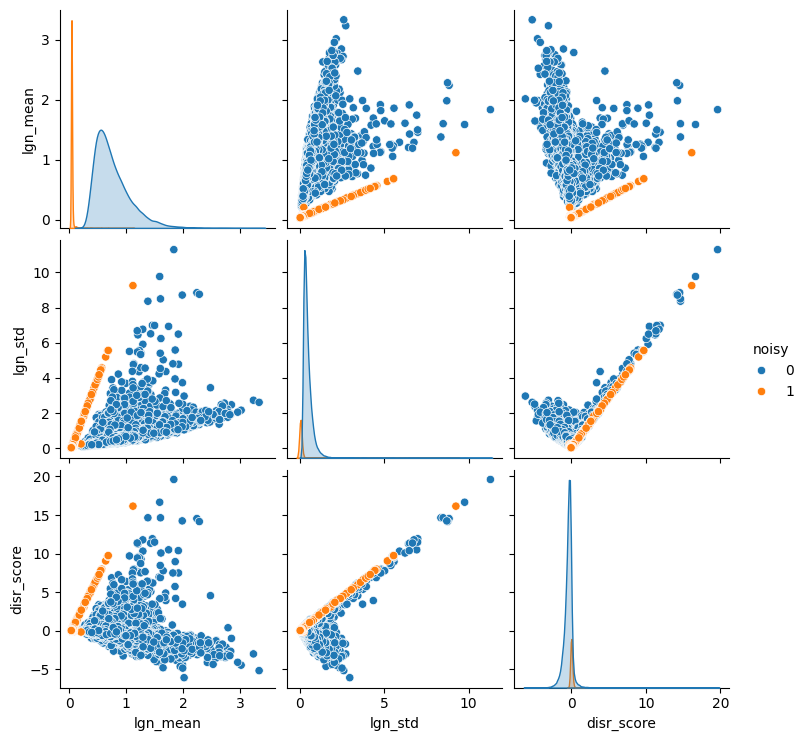

In [293]:
import seaborn as sns

sns.pairplot(df, kind='scatter', hue='noisy')
plt.show()

In [295]:
df.to_csv('../data/lgn_clear_noisy.csv', index=False)

## 3. Optimal threshold for statistic

Visually it's clear that best feature is either MSD disrepancy score or LGN mean. Let's fit DT and compare

In [339]:
lgn_stats = pd.read_csv('../data/lgn_clear_noisy.csv')

X_train_2 = lgn_stats['lgn_mean'].to_numpy()
y = msd_stats['noisy'].to_numpy()

In [340]:
X_train_2 = X_train_2.reshape(-1, 1)

In [341]:
from sklearn.tree import DecisionTreeClassifier

tree2 = DecisionTreeClassifier(max_depth=1, random_state=SEED).fit(X_train_2, y)
y_pred_2 = tree2.predict(X_train_2)

In [342]:
print(f"lgn mean thresh: {tree2.tree_.threshold[0]}")

lgn mean thresh: 0.21628089249134064


In [343]:
print("lgn mean res\n")
print(classification_report(y_pred_2, y))

lgn mean res

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50038
           1       0.99      1.00      1.00      4462

    accuracy                           1.00     54500
   macro avg       1.00      1.00      1.00     54500
weighted avg       1.00      1.00      1.00     54500

